In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### First Approach
We took OASIS Questionnaire Dataset ( https://www.kaggle.com/code/ahmedghobashi/detecting-early-alzheimer-s/input ) from Kaggle and did required data cleansing.After doing some analysis and research we tried to find out which all features have direct correlations with Alzheimer Probability ( Yes or No).  We tried different regression Models and compared the Accuracy Score among different Models. Here is Accuracy Score we found between different Models. As you see among these models Logistic Regression is best Model. This is one of the best and cheap option to detect Alzheimer in earlier stage. We had built a simple UI to predict the Alzheimer probality based on questionnaire.

--------------------------------------------------
Regression Model - Linear Regression
--------------------------------------------------

Training Score 0.6296831948363727
Testing Score  0.5670371522233935

--------------------------------------------------

Regression Model - KNeighbors
--------------------------------------------------

Training Score 0.2471635150166851
Testing Score  -0.012499999999999956

--------------------------------------------------
Regression Model - SVR
--------------------------------------------------

Training Score -0.49993608812335566
Testing Score  -0.4333856865131802

--------------------------------------------------
Regression Model - Random Forest
--------------------------------------------------

Training Score 0.9504849833147943
Testing Score  0.6629017857142858

--------------------------------------------------
Regression Model - Logistic Regression
--------------------------------------------------

Testing Score : 0.9333333333333333

--------------------------------------------------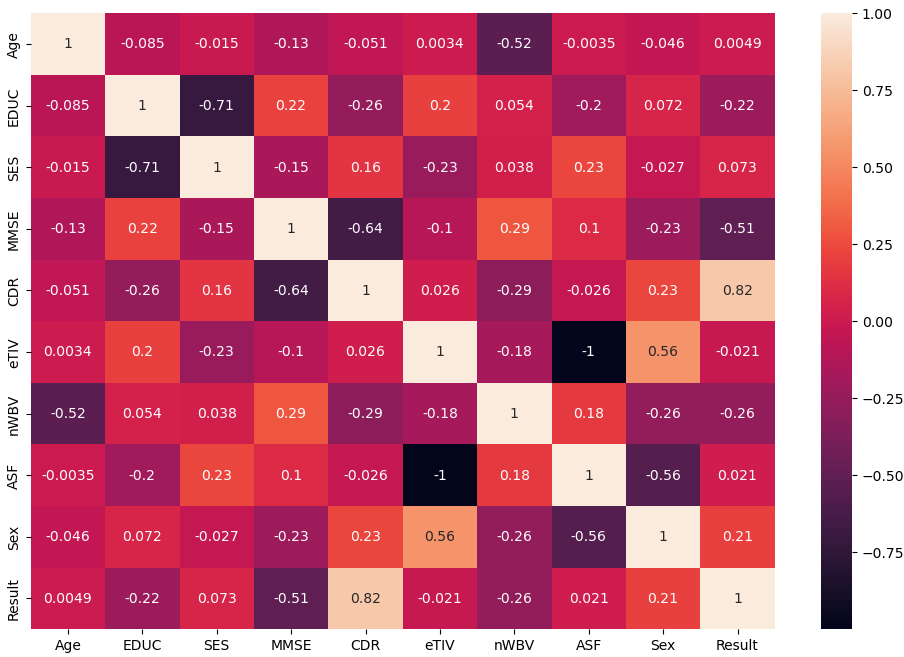

### Feature Descriptoion for Questionnaire

Subject ID : Subject Identification Number

MRI ID : MRI Exam Identification Number

Group : Class of dimentia - Nondemented and Demented

Visit : Nos of Patient vision ( subject ID ) . So multiple times these examinations been conducted.

MR Delay : MR Delay Time

M/F : Sex

Hand : Right or left handed

Age : Age of the subject

Education : Years of Education

SES : Socio economic Status ( 1 - 5 )

MMSE : Mini Mental State Examination

CDR : Clinical Dementia Rating

eTIV : Estimated Total Intracranial Volume

nWBV : Normalize Whole Brain Volume

In [ ]:
# Load Longitudinal MRI Data
import pandas as pd
long_mri_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/final project/oasis_longitudinal.csv')

long_mri_df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


### Second Approach

Next we explored supplementary image processing techniques using an OASIS MRI dataset. Our objective was to create a Convolutional Neural Network starting with 6 hidden layers and ending with 14 ones that could determine if a new image of a MRI scan could lead to the diagnosis of Alzheimer's disease. We used the Rectified Linear Unit (ReLU) for the Activation function for the Input and hidden layers and used Softmax Activation for the output layer. Since it is multi-class classification problem with more than three categories, softmax activation in the output layer is a common and appropriate choice instead of sigmoid activation. Images were organized on Google Drive and catagorized into three classes: Moderate Demented, Mild Demented, and Very Mild Demented.
Initial accuracy was 74% and improved to 85% as the hidden layers increased.

121/121 [==============================] - 2s 13ms/step - loss: 0.3601 - accuracy: 0.8582
Test Accuracy: 85.82%

In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import joblib

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

## Convolutional Neural Network (CNN) model for classification
* A characteristic sign of Alzheimer's disease is shrinking of a brain region called the hippocampus. This can easily be seen on an MRI scan.
* The original MRI image dataset we tried to use is too large, totaling 1.36 GB, to be executed on Google Colaboratory, even when utilizing a T4 GPU.
* The focus was narrowed down to classify dementia into three categories: very mild dementia, mild dementia, and moderate dementia.

In [ ]:
# set up path
base_path = '/content/gdrive/MyDrive/Colab Notebooks/final project/Alzheimer Dataset (OASIS)'

moderate_demented_path = os.path.join(base_path, 'Moderate_Demented')
mild_demented_path = os.path.join(base_path, 'Mild_Demented')
very_mild_demented_path = os.path.join(base_path, 'Very_Mild_Demented')
# non_demented_path = os.path.join(base_path, 'Non_Demented_sh')

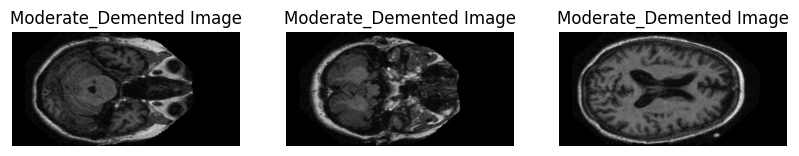

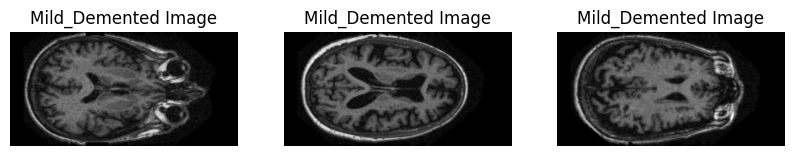

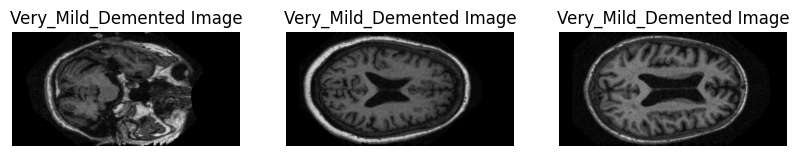

In [ ]:
# Visualize images for different classes
# classes = ["Moderate_Demented", "Mild_Demented", "Very_Mild_Demented", "Non_Demented_sh"]
classes = ["Moderate_Demented", "Mild_Demented", "Very_Mild_Demented"]

for class_name in classes:
    class_path = os.path.join(base_path, class_name)
    image_paths = [os.path.join(class_path, filename) for filename in os.listdir(class_path) if filename.endswith(".jpg")]

    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    for i, img_path in enumerate(image_paths[:3]):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"{class_name} Image", fontsize= 12)

    plt.show()

# Build CNN model
* 16 layers: 1 input layer, 14 hidden layers, 1 output layer
1. 4 Convolutional Layers with ReLU activation.
2. 4 MaxPooling Layers with pool size (2, 2).
3. 2 BatchNormalization Layers
4. 3 Dropout Layers with a dropout rate of 0.25 or 0.5
5. BatchNormalization Layer
6. Flatten Layer
7. Dense (Fully Connected) Layer with 512 units and ReLU activation
8. Dense Layer with 3 units (assuming 3 classes) and softmax activation for classification. (output layer)

* Use early stopping for preventing overfitting.

In [ ]:
# Load the trained CNN model
model = load_model("/content/gdrive/MyDrive/Colab Notebooks/final project/Alzheimer(OASIS)ThreeCategories.h5")

In [ ]:
# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 54, 54, 64)        256       
 Normalization)                                                  
                                                        

In [ ]:
import pickle
# Open the file in binary read mode and load the dictionary using pickle
with open("/content/gdrive/MyDrive/Colab Notebooks/final project/Alzheimer(OASIS)CombinedMetrics.pkl", "rb") as file:
    loaded_combined_metrics = pickle.load(file)

# Access the loaded metrics
loaded_history = loaded_combined_metrics['history']
loaded_test_loss = loaded_combined_metrics['test_loss']
loaded_test_accuracy = loaded_combined_metrics['test_accuracy']

# Print the test loss and test accuracy
print(f"Test Loss: {loaded_test_loss:.4f}")
print(f"Test Accuracy: {loaded_test_accuracy :.4f}")

Test Loss: 0.3601
Test Accuracy: 0.8582


### Third approach

In this approach , we had tried to predict using the same SVM model , we tried to predict different type of Alzheimer. We got pretty good test score there also. Model is present in  alzheimer-detection-and-classification-98-7-acc.ipynb under SVM_MRI_Image_processing_Model Folder. 1st part of the Program is 3rd Approach and later we did one step further and truied to predit different class of Alzheimer.

Train Accuracy :  1.0
Test Accuracy :  0.98671875

### Fourth Approach

We tried to use SVM Model ( Supervised Model ) using the Image. First we had tried to use Image to predict Alzheimer or Non Alzheimer ( Binary prediction ). We had tried SVM Model with different kernel and among them we found that SVM with linear Karnel has better result among them : 97.7 %

Accuracy :  1.0
Precision :  1.0
Recall :  1.0
f1 :  1.0
Confusion matrix : [[2546    0]
 [   0 2574]]
Accuracy :  0.97734375
Precision :  0.9776
Recall :  0.9760383386581469
f1 :  0.9768185451638689
Confusion matrix : [[640  14]
 [ 15 611]]

 Here is the result for SVM with Poly Kernel ( Degree : 2 )

 Accuracy :  0.8978515625
Precision :  0.8910776361529548
Recall :  0.9054160125588697
f1 :  0.8981896048277204
Confusion matrix : [[2290  282]
 [ 241 2307]]
Accuracy :  0.834375
Precision :  0.8459119496855346
Recall :  0.8251533742331288
f1 :  0.8354037267080745
Confusion matrix : [[530  98]
 [114 538]]

 Here is the result with rbf kernerl

 Accuracy :  0.8669921875
Precision :  0.8487112439297722
Recall :  0.8916797488226059
f1 :  0.8696650717703348
Confusion matrix : [[2167  405]
 [ 276 2272]]
Accuracy :  0.81640625
Precision :  0.8088888888888889
Recall :  0.8374233128834356
f1 :  0.8229088168801808
Confusion matrix : [[499 129]
 [106 546]]

#List where arrays shall be stored
resized_image_array=[]
#List that will store the answer if an image is female (0) or male (1)
resized_image_array_label=[]

width = 256
height = 256
new_size = (width,height) #the data is just black to white

#Iterate over pictures and resize them to 224 by 224
def resizer(image_directory):
    for file in image_directory: #tried with os.listdir but could work with os.walk as well
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))  # Resize to a common size
        array_temp = np.array(img)
        img_wide = array_temp.reshape(1, 150528)
        resized_image_array.append(img_wide[0])
        
        if image_directory == non:
            resized_image_array_label.append(0)
        else:
            resized_image_array_label.append(1)

ALZ = very_mild + mild + moderate
resizer(non)
resizer(ALZ)

## Predict OASIS(Open Access Series of Imaging Studies) cross-sectional data with Log. Regress., CNN, and SVM

In [ ]:
 # Raw sample data from Cross Sectional Data
cross_sectional_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/final project/cross_sectional_df.csv')

cross_sectional_df

,ID,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Group
0,OAS1_0001_MR1,F,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,Non Demented
1,OAS1_0002_MR1,F,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,Non Demented
2,OAS1_0003_MR1,F,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,Very Mild Dementia
3,OAS1_0010_MR1,M,74,5.0,2.0,30.0,0.0,1636,0.689,1.073,Non Demented
4,OAS1_0011_MR1,F,52,3.0,2.0,30.0,0.0,1321,0.827,1.329,Non Demented
...,...,...,...,...,...,...,...,...,...,...,...
177,OAS1_0373_MR1,F,80,3.0,2.0,20.0,1.0,1732,0.692,1.013,Mild Dementia
178,OAS1_0374_MR1,F,73,3.0,3.0,29.0,0.5,1238,0.760,1.418,Very Mild Dementia
179,OAS1_0378_MR1,F,58,2.0,2.0,30.0,0.0,1418,0.821,1.238,Non Demented
180,OAS1_0380_MR1,F,83,1.0,5.0,18.0,0.5,1313,0.705,1.337,Very Mild Dementia


## Clean the raw data
* Remove the 'Delay' and 'Hand' columns
* Remove rows containing NaN values
* Add a new 'Group' column, which corresponds to the folder name including the relevant images for each subject ID, using the following function. (The folder name presents the statue of demented of each subject id.)
* Remove rows with NaN values again. (Some subject IDs may have no associated images.)
* We got the sample data with 182 subject ids with all information.
* Save the resulting data frame as 'cross_sectional_df.csv.'

In [ ]:
# Function to get folder name for a given ID to classify the group the subject ids

def get_folder_for_id(id_value):
    base_dir = '/content/gdrive/MyDrive/Colab Notebooks/final project/Alzheimer Dataset (OASIS)/'
    # Dictionary to map subdirectories to dementia categories
    subdirectory_mapping = {
        'Moderate_Demented': 'Moderate Dementia',
        'Mild_Demented': 'Mild Dementia',
        'Very_Mild_Demented': 'Very Mild Dementia',
        'Non Demented_by_one': 'Non Demented'
    }

    for subdir in subdirectory_mapping:
        subdir_path = os.path.join(base_dir, subdir)

        # List all files in the subdirectory
        files = os.listdir(subdir_path)

        # Check if any file contains the current ID in its name
        matching_files = [file for file in files if id_value in file]

        if matching_files:
            return subdirectory_mapping[subdir]  # Return the corresponding dementia category

    return None  # Return None if no match is found

In [ ]:
cross_sectional_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/final project/cross_sectional_df.csv')
cross_sectional_df_copy = cross_sectional_df.copy()
cross_sectional_df_copy

,ID,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Group
0,OAS1_0001_MR1,F,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,Non Demented
1,OAS1_0002_MR1,F,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,Non Demented
2,OAS1_0003_MR1,F,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,Very Mild Dementia
3,OAS1_0010_MR1,M,74,5.0,2.0,30.0,0.0,1636,0.689,1.073,Non Demented
4,OAS1_0011_MR1,F,52,3.0,2.0,30.0,0.0,1321,0.827,1.329,Non Demented
...,...,...,...,...,...,...,...,...,...,...,...
177,OAS1_0373_MR1,F,80,3.0,2.0,20.0,1.0,1732,0.692,1.013,Mild Dementia
178,OAS1_0374_MR1,F,73,3.0,3.0,29.0,0.5,1238,0.760,1.418,Very Mild Dementia
179,OAS1_0378_MR1,F,58,2.0,2.0,30.0,0.0,1418,0.821,1.238,Non Demented
180,OAS1_0380_MR1,F,83,1.0,5.0,18.0,0.5,1313,0.705,1.337,Very Mild Dementia


## Predict the cleaned sample data using logistic regression model


In [ ]:
# Load the trained logistic regression model
# Change the path to your own.
trained_model = joblib.load('/content/gdrive/MyDrive/Colab Notebooks/final project/final_model.pkl')

# Load the list of feature names
# Change the path to your own.
feature_names = joblib.load('/content/gdrive/MyDrive/Colab Notebooks/final project/column_names.pkl')

In [ ]:
# Refine the sample data to match the format used for training the logistic regression model.

# Rename 'Educ' column to 'EDUC' in-place
cross_sectional_df_copy.rename(columns={'M/F': 'Sex'}, inplace=True)

# Replace 'F' with 1 and 'M' with 0 in the 'Sex' column using .loc
cross_sectional_df_copy['Sex'] = cross_sectional_df_copy['Sex'].replace({'F': 1, 'M': 0})

# Rename 'Educ' column to 'EDUC' in-place
cross_sectional_df_copy.rename(columns={'Educ': 'EDUC'}, inplace=True)

In [ ]:
# Select features for prediction
X_sample = cross_sectional_df_copy[feature_names]

# Create a new StandardScaler and fit_transform on the same data used for training
scaler = StandardScaler()
X_sample_scaled = pd.DataFrame(scaler.fit_transform(X_sample), columns=X_sample.columns)

# Make predictions using the trained model
predictions = trained_model.predict(X_sample_scaled)

# Create a new column for predicted values and initialize with NaN
cross_sectional_df_copy['predicted'] = np.nan

# Fill predicted values for non-NaN rows
cross_sectional_df_copy = cross_sectional_df_copy.reindex(X_sample_scaled.index)
cross_sectional_df_copy.loc[X_sample_scaled.index, 'predicted'] = predictions

# Replace 0 and 1 with 'Nondemented' and 'Demented'
cross_sectional_df_copy['predicted'] = cross_sectional_df_copy['predicted'].replace({0: 'Nondemented', 1: 'Demented'})

# Check the updated dataframe
cross_sectional_df_copy

<ipython-input-23-a260cd7f3be5>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  cross_sectional_df_copy.loc[X_sample_scaled.index, 'predicted'] = predictions


,ID,Sex,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Group,predicted
0,OAS1_0001_MR1,1,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,Non Demented,Nondemented
1,OAS1_0002_MR1,1,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,Non Demented,Demented
2,OAS1_0003_MR1,1,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,Very Mild Dementia,Demented
3,OAS1_0010_MR1,0,74,5.0,2.0,30.0,0.0,1636,0.689,1.073,Non Demented,Nondemented
4,OAS1_0011_MR1,1,52,3.0,2.0,30.0,0.0,1321,0.827,1.329,Non Demented,Nondemented
...,...,...,...,...,...,...,...,...,...,...,...,...
177,OAS1_0373_MR1,1,80,3.0,2.0,20.0,1.0,1732,0.692,1.013,Mild Dementia,Demented
178,OAS1_0374_MR1,1,73,3.0,3.0,29.0,0.5,1238,0.760,1.418,Very Mild Dementia,Demented
179,OAS1_0378_MR1,1,58,2.0,2.0,30.0,0.0,1418,0.821,1.238,Non Demented,Nondemented
180,OAS1_0380_MR1,1,83,1.0,5.0,18.0,0.5,1313,0.705,1.337,Very Mild Dementia,Demented


In [ ]:
# Count the occurrences of each combination of 'Group' and 'predicted'
count_table = cross_sectional_df_copy.groupby(['Group', 'predicted']).size().unstack(fill_value=0)
count_table

predicted,Demented,Nondemented
Group,,
Mild Dementia,18,0
Moderate Dementia,2,0
Non Demented,9,108
Very Mild Dementia,44,1


## Classify dementia using CNN model

In [ ]:
# Choose one subject id in sample data
#id_value = 'OAS1_0003_MR1'  # Very Mild Dementia
id_value = 'OAS1_0373_MR1' # Mild Dementia
# Each patient took at most 4 MRI. Select the desired MRI number (1 for the first, 2 for the second, etc.)
mri_number = 1

group_for_id = cross_sectional_df_copy.loc[cross_sectional_df_copy['ID'] == id_value, 'Group'].values[0]

if group_for_id == 'Very Mild Dementia':
    image_folder = "/content/gdrive/MyDrive/Colab Notebooks/final project/Alzheimer Dataset (OASIS)/Very_Mild_Demented"
elif group_for_id == 'Mild Dementia':
    image_folder = "/content/gdrive/MyDrive/Colab Notebooks/final project/Alzheimer Dataset (OASIS)/Mild_Demented"
elif group_for_id == 'Non Demented':
    image_folder = "/content/gdrive/MyDrive/Colab Notebooks/final project/Alzheimer Dataset (OASIS)/Non_Demented_sample"

image_name_prefix = f"{id_value}_mpr-{mri_number}"

In [ ]:
# Load the trained model
model = load_model("/content/gdrive/MyDrive/Colab Notebooks/final project/Alzheimer(OASIS)ThreeCategories.h5")

In [ ]:
# Get a list of image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]

# Filter filenames based on the image name prefix
filtered_files = [f for f in image_files if f.startswith(image_name_prefix)]

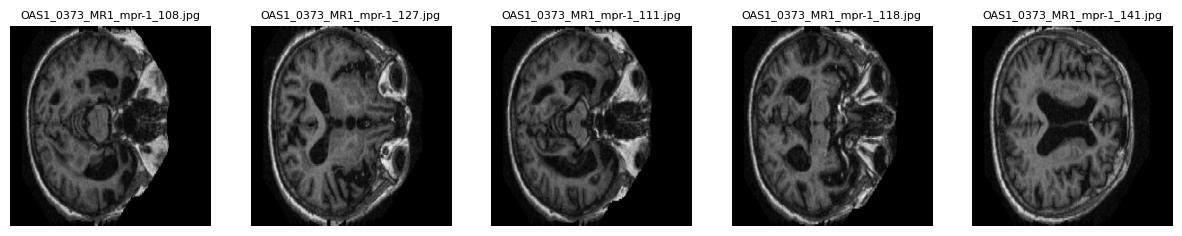

In [ ]:
# Display the first 5 filtered images
import random

num_images_to_display = 5

# Randomly select five images from the filtered_files list
random_images = random.sample(filtered_files, num_images_to_display)

# Display the randomly selected images
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))
for i, image_file in enumerate(random_images):
    img_path = os.path.join(image_folder, image_file)
    img = image.load_img(img_path, target_size=(224, 224))

    # Display the image
    plt.subplot(1, num_images_to_display, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(image_file, fontsize=8)

plt.show()

In [ ]:
class_labels = ['Mild_Dementia' 'Moderate_Dementia' 'Very_Mild_Dementia']
# Create a list to store DataFrames
dfs = []

# Loop through each filtered image and make predictions
for image_file in filtered_files:
    # Load and preprocess the image
    img_path = os.path.join(image_folder, image_file)
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values to between 0 and 1

    # Make prediction
    prediction = model.predict(img_array)

    # Round the prediction values to two decimal places
    rounded_prediction = np.round(prediction, 2)

    # print(f"Prediction for {image_file}: {rounded_prediction}")

    # Create a DataFrame for each prediction
    result_df = pd.DataFrame({
        'Image_Name': [image_file],
        'Predicted_Mild_Dementia': [rounded_prediction[0][0]],  # Index 0 corresponds to 'Mild_Demented'
        'Predicted_Moderate_Dementia': [rounded_prediction[0][1]],  # Index 1 corresponds to 'Moderate_Demented'
        'Predicted_Very_Mild_Dementia': [rounded_prediction[0][2]]  # Index 2 corresponds to 'Very_Mild_Demented'
    })

    # Append the DataFrame to the list
    dfs.append(result_df)

# Concatenate all DataFrames in the list into one DataFrame
result_df = pd.concat(dfs, ignore_index=True)

1/1 [==============================] - 0s 26ms/step


In [ ]:
result_df.sort_values(by='Predicted_Very_Mild_Dementia', ascending=False)
# Assuming 'result_df' is your DataFrame
column_means = result_df.mean()

# Display the means with 'ID' and 'Group' values
print("Column Means:")
print(f"ID: {id_value}, Group: {group_for_id}\n")
print(column_means)

Column Means:
ID: OAS1_0373_MR1, Group: Mild Dementia

Predicted_Mild_Dementia         0.834262
Predicted_Moderate_Dementia     0.000000
Predicted_Very_Mild_Dementia    0.165738
dtype: float32


<ipython-input-30-27abb5951f2a>:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  column_means = result_df.mean()


## Predict sample data using SVM model

In [ ]:
# Load the trained logistic regression model
svm_model = joblib.load('/content/gdrive/MyDrive/Colab Notebooks/final project/final_model.pkl')

### Things to improve

1. Improve the CNN Model to get better Accuracy
2. Try to use some pre build CNN Model and train that Model to see if that give us good accuracy score.
3. build an UI to use the best Model and predict different type of Alzheimer ( Where User ccvan either submit the questionnairee or ipload Image or bith).  